<h1>Self Driving Car<h1>

In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

<h2>Problem Statement<h2>

We have images captured by the front camera and the steering wheel angle values at that particular instant,captured from the CAN bus in vehicle.We are going to train a model, so that it can predict the steering wheel angle values when we feed 
it with new road images or the images captured by the front camera when the vehcile is being driven in real time.

<h2>1.Loading Data:<h2>

We will split the dataset into train and test in 70:30 ratio.

In [6]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

print('Total number of datapoints:',num_images)
print('Number of Train datapoints:',num_train_images)
print('Number of Test datapoints:',num_val_images)

Total number of datapoints: 45406
Number of Train datapoints: 31784
Number of Test datapoints: 13621


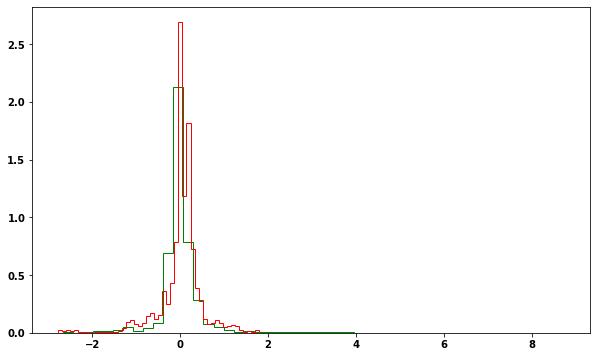

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (10, 6))
plt.hist(train_ys, bins=50, normed=1, color='green', histtype ='step');
plt.hist(val_ys, bins=50, normed=1, color='red', histtype ='step');
plt.show()

In [4]:
import numpy as np
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_ys)
print('Test_MSE(MEAN):%f' % np.mean(np.square(val_ys-train_mean_y)) )
print('Test_MSE(ZERO):%f' % np.mean(np.square([i-0.0 for i in val_ys])) )

Test_MSE(MEAN):0.241559
Test_MSE(ZERO):0.241108


In [5]:
# scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0
# you can break the whole line into parts like this
# here (train_batch_pointer + i) % num_train_images => "% num_train_images" is used to make sure that the
# (train_batch_pointer + i) values should not cross number of train images.

# lets explain whats happening with the first images
image_read = scipy.misc.imread(train_xs[0])
print("original image size",image_read.shape)

print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
image_read = image_read[-150:]
resized_image = scipy.misc.imresize(image_read, [66, 200])
print("After resizing the images into 66*200, ",resized_image.shape)
# 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it

original image size (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
After resizing the images into 66*200,  (66, 200, 3)


In [7]:
#Functions to load the Train and Test data in batch
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

<h2>2.Defining Model:<h2>

In [1]:
import tensorflow as tf
import scipy

#To stop the warnings from printing.
tf.logging.set_verbosity(tf.logging.ERROR)


def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

#y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output
#y = tf.matmul(h_fc4_drop, W_fc5) + b_fc5
y = tf.keras.activations.linear(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)

<h2>3.Training the model:<h2>

In [1]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model


#To stop the warnings from printing.
tf.logging.set_verbosity(tf.logging.ERROR)


LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

#epoch_num, test_loss,  = [], []
#train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)


 #Saving the average Test logs at the end of each epoch
  '''te_avg_loss = 0
  for i in range(int(num_val_images/batch_size)):
    xs, ys = LoadValBatch(batch_size)
    loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
    te_avg_loss += loss_value / batch_size
  epoch_num.append(epoch)
  test_loss.append(te_avg_loss)'''

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


/home/mitmakshay/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mitmakshay/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mitmakshay/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mitmakshay/.local/lib/python3.5/site-packages/tensorflow/python/framework

Epoch: 0, Step: 0, Loss: 7.23927
Epoch: 0, Step: 10, Loss: 6.15085
Epoch: 0, Step: 20, Loss: 6.11055
Epoch: 0, Step: 30, Loss: 6.08727
Epoch: 0, Step: 40, Loss: 6.31588
Epoch: 0, Step: 50, Loss: 5.95452
Epoch: 0, Step: 60, Loss: 6.04857
Epoch: 0, Step: 70, Loss: 6.19643
Epoch: 0, Step: 80, Loss: 6.02859
Epoch: 0, Step: 90, Loss: 5.79539
Epoch: 0, Step: 100, Loss: 5.73596
Epoch: 0, Step: 110, Loss: 5.66733
Epoch: 0, Step: 120, Loss: 5.64613
Epoch: 0, Step: 130, Loss: 5.89964
Epoch: 0, Step: 140, Loss: 6.32584
Epoch: 0, Step: 150, Loss: 5.80418
Epoch: 0, Step: 160, Loss: 6.32924
Epoch: 0, Step: 170, Loss: 5.68333
Epoch: 0, Step: 180, Loss: 6.00784
Epoch: 0, Step: 190, Loss: 5.70039
Epoch: 0, Step: 200, Loss: 5.31908
Epoch: 0, Step: 210, Loss: 5.26713
Epoch: 0, Step: 220, Loss: 5.26726
Epoch: 0, Step: 230, Loss: 5.31399
Epoch: 0, Step: 240, Loss: 6.22611
Epoch: 0, Step: 250, Loss: 5.30876
Epoch: 0, Step: 260, Loss: 7.08992
Epoch: 0, Step: 270, Loss: 5.58917
Epoch: 0, Step: 280, Loss: 6.17

Epoch: 5, Step: 500, Loss: 1.89978
Epoch: 5, Step: 510, Loss: 1.8959
Epoch: 5, Step: 520, Loss: 1.88794
Epoch: 5, Step: 530, Loss: 1.88127
Epoch: 5, Step: 540, Loss: 1.87438
Epoch: 5, Step: 550, Loss: 1.86795
Epoch: 5, Step: 560, Loss: 1.85972
Epoch: 5, Step: 570, Loss: 1.85384
Epoch: 5, Step: 580, Loss: 1.85895
Epoch: 5, Step: 590, Loss: 1.89655
Epoch: 5, Step: 600, Loss: 4.64967
Epoch: 5, Step: 610, Loss: 4.62888
Epoch: 5, Step: 620, Loss: 1.82062
Epoch: 5, Step: 630, Loss: 1.81142
Epoch: 5, Step: 640, Loss: 1.8518
Epoch: 5, Step: 650, Loss: 1.84524
Epoch: 5, Step: 660, Loss: 1.83044
Epoch: 5, Step: 670, Loss: 1.84367
Epoch: 5, Step: 680, Loss: 1.90885
Epoch: 5, Step: 690, Loss: 1.77334
Epoch: 5, Step: 700, Loss: 1.7921
Epoch: 5, Step: 710, Loss: 1.7804
Epoch: 5, Step: 720, Loss: 1.76741
Epoch: 5, Step: 730, Loss: 1.75341
Epoch: 5, Step: 740, Loss: 1.81942
Epoch: 5, Step: 750, Loss: 1.80409
Epoch: 5, Step: 760, Loss: 1.81812
Epoch: 5, Step: 770, Loss: 1.81685
Epoch: 5, Step: 780, Los

Epoch: 9, Step: 1340, Loss: 0.869998
Epoch: 9, Step: 1350, Loss: 0.864989
Model saved in file: ./save/model.ckpt
Epoch: 10, Step: 1000, Loss: 0.954433
Epoch: 10, Step: 1010, Loss: 1.52173
Epoch: 10, Step: 1020, Loss: 2.07028
Epoch: 10, Step: 1030, Loss: 1.00149
Epoch: 10, Step: 1040, Loss: 0.929472
Epoch: 10, Step: 1050, Loss: 0.827817
Epoch: 10, Step: 1060, Loss: 0.832393
Epoch: 10, Step: 1070, Loss: 0.824277
Epoch: 10, Step: 1080, Loss: 0.822811
Epoch: 10, Step: 1090, Loss: 0.836168
Epoch: 10, Step: 1100, Loss: 0.861359
Epoch: 10, Step: 1110, Loss: 0.815065
Epoch: 10, Step: 1120, Loss: 0.905218
Epoch: 10, Step: 1130, Loss: 1.18153
Epoch: 10, Step: 1140, Loss: 0.886257
Epoch: 10, Step: 1150, Loss: 0.961239
Epoch: 10, Step: 1160, Loss: 0.795391
Epoch: 10, Step: 1170, Loss: 0.800131
Epoch: 10, Step: 1180, Loss: 0.79072
Epoch: 10, Step: 1190, Loss: 0.788009
Epoch: 10, Step: 1200, Loss: 0.837506
Epoch: 10, Step: 1210, Loss: 5.06611
Epoch: 10, Step: 1220, Loss: 1.66974
Epoch: 10, Step: 123

Epoch: 14, Step: 1660, Loss: 0.379432
Epoch: 14, Step: 1670, Loss: 0.368137
Epoch: 14, Step: 1680, Loss: 0.367485
Epoch: 14, Step: 1690, Loss: 0.383092
Epoch: 14, Step: 1700, Loss: 0.354524
Epoch: 14, Step: 1710, Loss: 0.370113
Epoch: 14, Step: 1720, Loss: 0.354854
Epoch: 14, Step: 1730, Loss: 0.371464
Epoch: 14, Step: 1740, Loss: 0.483371
Epoch: 14, Step: 1750, Loss: 0.354441
Epoch: 14, Step: 1760, Loss: 0.359419
Epoch: 14, Step: 1770, Loss: 0.753124
Epoch: 14, Step: 1780, Loss: 0.353455
Epoch: 14, Step: 1790, Loss: 0.375565
Epoch: 14, Step: 1800, Loss: 0.415374
Epoch: 14, Step: 1810, Loss: 0.605977
Epoch: 14, Step: 1820, Loss: 0.359432
Epoch: 14, Step: 1830, Loss: 0.383757
Epoch: 14, Step: 1840, Loss: 0.423104
Epoch: 14, Step: 1850, Loss: 0.43707
Model saved in file: ./save/model.ckpt
Epoch: 15, Step: 1500, Loss: 0.372595
Epoch: 15, Step: 1510, Loss: 0.372792
Epoch: 15, Step: 1520, Loss: 0.33554
Epoch: 15, Step: 1530, Loss: 0.376868
Epoch: 15, Step: 1540, Loss: 0.410981
Epoch: 15, St

Epoch: 19, Step: 1980, Loss: 0.554525
Epoch: 19, Step: 1990, Loss: 0.44155
Epoch: 19, Step: 2000, Loss: 0.222135
Epoch: 19, Step: 2010, Loss: 0.349213
Epoch: 19, Step: 2020, Loss: 0.372608
Epoch: 19, Step: 2030, Loss: 0.304592
Epoch: 19, Step: 2040, Loss: 0.20349
Epoch: 19, Step: 2050, Loss: 0.419675
Epoch: 19, Step: 2060, Loss: 4.71971
Epoch: 19, Step: 2070, Loss: 0.241137
Epoch: 19, Step: 2080, Loss: 0.178479
Epoch: 19, Step: 2090, Loss: 0.180259
Epoch: 19, Step: 2100, Loss: 0.187562
Epoch: 19, Step: 2110, Loss: 0.192023
Epoch: 19, Step: 2120, Loss: 0.187679
Epoch: 19, Step: 2130, Loss: 0.217559
Epoch: 19, Step: 2140, Loss: 0.20425
Epoch: 19, Step: 2150, Loss: 0.218942
Epoch: 19, Step: 2160, Loss: 0.207703
Epoch: 19, Step: 2170, Loss: 0.273092
Epoch: 19, Step: 2180, Loss: 0.183003
Epoch: 19, Step: 2190, Loss: 0.286267
Epoch: 19, Step: 2200, Loss: 0.420936
Epoch: 19, Step: 2210, Loss: 0.208459
Epoch: 19, Step: 2220, Loss: 0.226786
Epoch: 19, Step: 2230, Loss: 0.179302
Epoch: 19, Step:

Epoch: 23, Step: 2670, Loss: 0.149572
Epoch: 23, Step: 2680, Loss: 0.153584
Epoch: 23, Step: 2690, Loss: 0.311366
Epoch: 23, Step: 2700, Loss: 0.284373
Epoch: 23, Step: 2710, Loss: 0.283445
Epoch: 23, Step: 2720, Loss: 0.145557
Epoch: 23, Step: 2730, Loss: 0.159382
Epoch: 23, Step: 2740, Loss: 0.158634
Epoch: 23, Step: 2750, Loss: 0.275581
Model saved in file: ./save/model.ckpt
Epoch: 24, Step: 2400, Loss: 0.340984
Epoch: 24, Step: 2410, Loss: 0.483519
Epoch: 24, Step: 2420, Loss: 0.403645
Epoch: 24, Step: 2430, Loss: 0.163582
Epoch: 24, Step: 2440, Loss: 0.18455
Epoch: 24, Step: 2450, Loss: 0.17334
Epoch: 24, Step: 2460, Loss: 0.16674
Epoch: 24, Step: 2470, Loss: 0.164186
Epoch: 24, Step: 2480, Loss: 0.29746
Epoch: 24, Step: 2490, Loss: 0.301658
Epoch: 24, Step: 2500, Loss: 0.230823
Epoch: 24, Step: 2510, Loss: 0.614013
Epoch: 24, Step: 2520, Loss: 1.37661
Epoch: 24, Step: 2530, Loss: 0.218342
Epoch: 24, Step: 2540, Loss: 0.228568
Epoch: 24, Step: 2550, Loss: 0.190101
Epoch: 24, Step:

Epoch: 28, Step: 3000, Loss: 0.344239
Epoch: 28, Step: 3010, Loss: 0.180355
Epoch: 28, Step: 3020, Loss: 0.426077
Epoch: 28, Step: 3030, Loss: 0.169476
Epoch: 28, Step: 3040, Loss: 0.309643
Epoch: 28, Step: 3050, Loss: 0.219683
Epoch: 28, Step: 3060, Loss: 0.155181
Epoch: 28, Step: 3070, Loss: 0.169345
Epoch: 28, Step: 3080, Loss: 0.17243
Epoch: 28, Step: 3090, Loss: 0.161958
Epoch: 28, Step: 3100, Loss: 0.139238
Epoch: 28, Step: 3110, Loss: 0.159939
Epoch: 28, Step: 3120, Loss: 0.155466
Epoch: 28, Step: 3130, Loss: 0.156394
Epoch: 28, Step: 3140, Loss: 0.225145
Epoch: 28, Step: 3150, Loss: 0.155042
Epoch: 28, Step: 3160, Loss: 0.135067
Epoch: 28, Step: 3170, Loss: 0.3096
Epoch: 28, Step: 3180, Loss: 0.148805
Epoch: 28, Step: 3190, Loss: 0.130316
Epoch: 28, Step: 3200, Loss: 0.289625
Epoch: 28, Step: 3210, Loss: 0.173442
Epoch: 28, Step: 3220, Loss: 4.73872
Epoch: 28, Step: 3230, Loss: 0.830133
Epoch: 28, Step: 3240, Loss: 0.124432
Epoch: 28, Step: 3250, Loss: 0.145574
Model saved in f

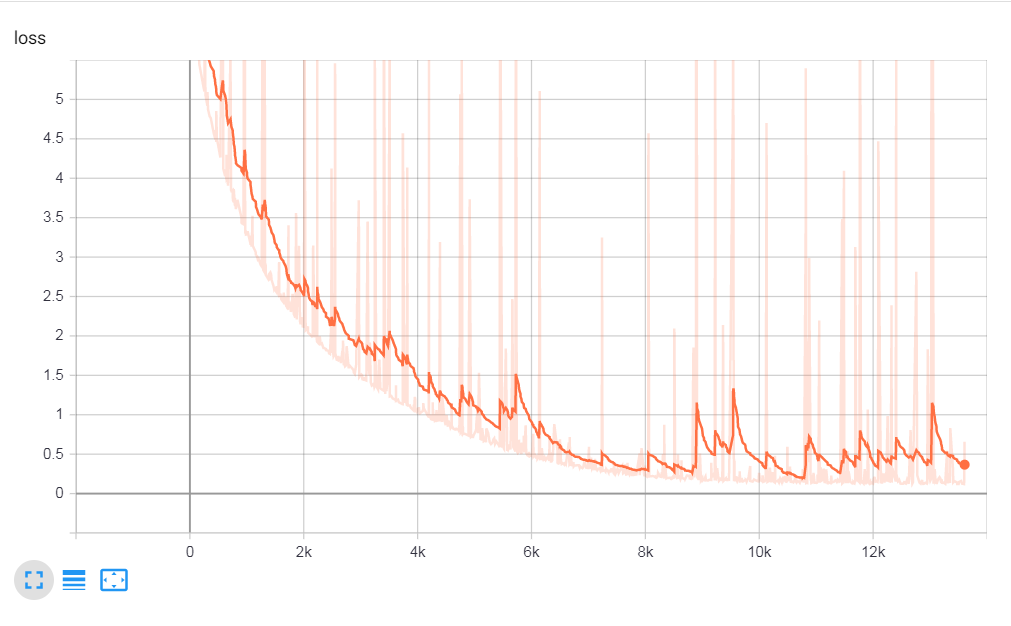

In [2]:
#Tensorboard plot(smoothed): Loss Vs Each_batch
from IPython.display import Image
Image(filename='Tensorboard_Plot_Loss_vs_Each_batch.PNG')

<h2>4.Visualizing the results:<h2>

In [1]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from save/model.ckpt
Starting frameofvideo:31785


C:\Users\AkKUmar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\AkKUmar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: -5.610251216790889 (pred)	-28.34 (actual)
Steering angle: -9.332913915877993 (pred)	-28.840000000000003 (actual)
Steering angle: -11.619608316032195 (pred)	-29.75 (actual)
Steering angle: -2.274710406368591 (pred)	-31.06 (actual)
Steering angle: -2.4178318977843305 (pred)	-32.27 (actual)
Steering angle: -0.030615469180935904 (pred)	-33.48 (actual)
Steering angle: 1.4868809558930007 (pred)	-34.39 (actual)
Steering angle: -0.6138739238254741 (pred)	-35.599999999999994 (actual)
Steering angle: 6.495218336981932 (pred)	-36.5 (actual)
Steering angle: 10.947406711128927 (pred)	-37.61 (actual)
Steering angle: 10.790447256454742 (pred)	-38.62 (actual)
Steering angle: 12.112836766566325 (pred)	-39.63 (actual)
Steering angle: 13.534906057425076 (pred)	-39.93000000000001 (actual)
Steering angle: 11.657408290446337 (pred)	-40.03000000000001 (actual)
Steering angle: 16.158479047822645 (pred)	-40.03000000000001 (actual)
Steering angle: 20.28068091948564 (pred)	-40.03000000000001 (act

Steering angle: 4.612977430511443 (pred)	-0.61 (actual)
Steering angle: 5.702196235189839 (pred)	-0.61 (actual)
Steering angle: 6.265218973757745 (pred)	-0.5 (actual)
Steering angle: 5.836478181159113 (pred)	-0.3 (actual)
Steering angle: 6.004159752169749 (pred)	0.2 (actual)
Steering angle: 5.494367239124691 (pred)	0.3 (actual)
Steering angle: 5.369484060340178 (pred)	0.4 (actual)
Steering angle: 3.620065573790696 (pred)	0.5 (actual)
Steering angle: 3.288141645459937 (pred)	1.01 (actual)
Steering angle: 1.834596068141418 (pred)	1.6100000000000003 (actual)
Steering angle: -4.519366699728656 (pred)	2.12 (actual)
Steering angle: -2.2685325002643144 (pred)	2.52 (actual)
Steering angle: -6.071002971595256 (pred)	3.13 (actual)
Steering angle: -2.820226516320108 (pred)	4.13 (actual)
Steering angle: 0.9337120458633075 (pred)	4.64 (actual)
Steering angle: 2.5709007059525475 (pred)	4.94 (actual)
Steering angle: 3.067531871353814 (pred)	4.94 (actual)
Steering angle: 3.5561025597608196 (pred)	4.94

Steering angle: 7.637791591248705 (pred)	23.39 (actual)
Steering angle: 7.544606466628575 (pred)	23.29 (actual)
Steering angle: 7.470423782053066 (pred)	22.89 (actual)
Steering angle: 9.297675262402604 (pred)	22.59 (actual)
Steering angle: 9.096885630050801 (pred)	22.59 (actual)
Steering angle: 8.88234511935247 (pred)	22.39 (actual)
Steering angle: 9.63022692780677 (pred)	22.08 (actual)
Steering angle: 7.935238645639944 (pred)	22.08 (actual)
Steering angle: 9.415426869919978 (pred)	22.08 (actual)
Steering angle: 8.452150777121094 (pred)	21.98 (actual)
Steering angle: 4.777141454099523 (pred)	21.78 (actual)
Steering angle: 8.814708317322772 (pred)	21.68 (actual)
Steering angle: 9.614148662500561 (pred)	21.68 (actual)
Steering angle: 9.364618800231547 (pred)	21.68 (actual)
Steering angle: 9.037460422950751 (pred)	0.0 (actual)
Steering angle: 7.670326343586415 (pred)	22.69 (actual)
Steering angle: 7.73545817373801 (pred)	23.189999999999998 (actual)
Steering angle: 8.039264134246531 (pred)

Steering angle: 16.75116017531404 (pred)	38.02 (actual)
Steering angle: 18.37007722559985 (pred)	38.32 (actual)
Steering angle: 18.749943318931987 (pred)	38.72 (actual)
Steering angle: 15.622575575354276 (pred)	39.13 (actual)
Steering angle: 11.884800655841694 (pred)	39.43 (actual)
Steering angle: 9.337839336043219 (pred)	39.830000000000005 (actual)
Steering angle: 7.947032674789264 (pred)	39.93000000000001 (actual)
Steering angle: 7.071743932652129 (pred)	39.93000000000001 (actual)
Steering angle: 7.190375780798789 (pred)	40.13 (actual)
Steering angle: 7.955814590514607 (pred)	40.64000000000001 (actual)
Steering angle: 8.231872053746304 (pred)	41.24 (actual)
Steering angle: 8.737980533507788 (pred)	41.75 (actual)
Steering angle: 8.99769420782929 (pred)	42.959999999999994 (actual)
Steering angle: 13.278149001240541 (pred)	43.97 (actual)
Steering angle: 17.79891460908858 (pred)	44.57 (actual)
Steering angle: 26.01431053900952 (pred)	45.18 (actual)
Steering angle: 50.28795761332505 (pred

Steering angle: 0.1014355662506825 (pred)	5.45 (actual)
Steering angle: 0.05137027963448903 (pred)	4.64 (actual)
Steering angle: 0.15498638377769808 (pred)	3.829999999999999 (actual)
Steering angle: 0.7638315808267503 (pred)	3.53 (actual)
Steering angle: 1.1343394612223232 (pred)	3.4300000000000006 (actual)
Steering angle: 0.7795819970527997 (pred)	3.4300000000000006 (actual)
Steering angle: 0.8394524471093696 (pred)	0.0 (actual)
Steering angle: 0.9159847167593625 (pred)	3.13 (actual)
Steering angle: 1.0831642688660028 (pred)	2.92 (actual)
Steering angle: 1.2612785269470101 (pred)	2.62 (actual)
Steering angle: 1.3304072984235324 (pred)	1.92 (actual)
Steering angle: 1.6665934782397913 (pred)	1.21 (actual)
Steering angle: 2.316405723043757 (pred)	1.01 (actual)
Steering angle: 3.1741613695814683 (pred)	1.01 (actual)
Steering angle: 4.2144790080103345 (pred)	1.01 (actual)
Steering angle: 5.242703796513694 (pred)	1.01 (actual)
Steering angle: 5.3351393078724145 (pred)	1.21 (actual)
Steering

Steering angle: -20.35932713268375 (pred)	-29.04 (actual)
Steering angle: -21.042808795001292 (pred)	-29.04 (actual)
Steering angle: -20.64426042674188 (pred)	-28.840000000000003 (actual)
Steering angle: -19.989639728762224 (pred)	-28.34 (actual)
Steering angle: -20.12830281419724 (pred)	-27.830000000000002 (actual)
Steering angle: -19.60564137098223 (pred)	-27.830000000000002 (actual)
Steering angle: -18.645991254858977 (pred)	-28.13 (actual)
Steering angle: -18.828207041536576 (pred)	-28.24 (actual)
Steering angle: -18.135386803076333 (pred)	-28.24 (actual)
Steering angle: -18.420834068869507 (pred)	-28.24 (actual)
Steering angle: -19.536320073548477 (pred)	-28.34 (actual)
Steering angle: -21.060770484971133 (pred)	-28.34 (actual)
Steering angle: -21.149745651741597 (pred)	-28.03 (actual)
Steering angle: -23.3924348506207 (pred)	-27.93 (actual)
Steering angle: -23.21328069623856 (pred)	-27.93 (actual)
Steering angle: -23.551228211087036 (pred)	-27.830000000000002 (actual)
Steering an

Steering angle: 2.266665297299962 (pred)	-35.39 (actual)
Steering angle: 3.039615394112091 (pred)	-33.58 (actual)
Steering angle: 3.420181581834154 (pred)	-31.969999999999995 (actual)
Steering angle: 5.352046160502312 (pred)	-31.359999999999996 (actual)
Steering angle: 6.9273217170863255 (pred)	-31.06 (actual)
Steering angle: 8.325032418930695 (pred)	-30.449999999999992 (actual)
Steering angle: 9.882040634579509 (pred)	-29.34 (actual)
Steering angle: 13.03934851238397 (pred)	-28.03 (actual)
Steering angle: 9.458640623025003 (pred)	-27.130000000000003 (actual)
Steering angle: 4.437690016973175 (pred)	-26.02 (actual)
Steering angle: 3.255442541695324 (pred)	-25.71 (actual)
Steering angle: 12.982268621490174 (pred)	-24.200000000000003 (actual)
Steering angle: 13.344512826763678 (pred)	-22.49 (actual)
Steering angle: -2.3531969638948538 (pred)	-21.18 (actual)
Steering angle: -3.596007939986619 (pred)	-20.57 (actual)
Steering angle: -5.7338802020890585 (pred)	-20.370000000000005 (actual)
St

Steering angle: 2.8075133998405986 (pred)	0.1 (actual)
Steering angle: 3.0072573729191556 (pred)	-0.5 (actual)
Steering angle: 2.126830407535468 (pred)	-0.91 (actual)
Steering angle: 1.9704711557345973 (pred)	-1.21 (actual)
Steering angle: 1.741721503685112 (pred)	-1.6100000000000003 (actual)
Steering angle: 2.484624531121297 (pred)	-2.22 (actual)
Steering angle: 1.9597193707639395 (pred)	-3.3299999999999996 (actual)
Steering angle: 0.9743508176512371 (pred)	-4.03 (actual)
Steering angle: 0.9636841966017928 (pred)	-5.340000000000001 (actual)
Steering angle: 1.629261371783794 (pred)	-6.76 (actual)
Steering angle: 2.335897802274504 (pred)	-8.469999999999999 (actual)
Steering angle: 2.6981025205168687 (pred)	-9.380000000000003 (actual)
Steering angle: 2.9315882684255232 (pred)	-10.08 (actual)
Steering angle: 3.1237774119518114 (pred)	-11.5 (actual)
Steering angle: 2.8603067066999777 (pred)	-13.610000000000001 (actual)
Steering angle: 3.3231467918430755 (pred)	-14.82 (actual)
Steering angl

Steering angle: 5.3731249780546175 (pred)	4.64 (actual)
Steering angle: 5.367042694598721 (pred)	4.64 (actual)
Steering angle: 5.415443549491547 (pred)	4.64 (actual)
Steering angle: 5.544131570530581 (pred)	4.64 (actual)
Steering angle: 5.578253488076672 (pred)	4.64 (actual)
Steering angle: 5.59622030068839 (pred)	4.54 (actual)
Steering angle: 5.652684193896416 (pred)	4.44 (actual)
Steering angle: 5.508225692950647 (pred)	4.44 (actual)
Steering angle: 5.426495649342274 (pred)	4.44 (actual)
Steering angle: 5.477390803942624 (pred)	4.24 (actual)
Steering angle: 5.547072393855094 (pred)	4.13 (actual)
Steering angle: 5.579497009392437 (pred)	4.13 (actual)
Steering angle: 5.569891202098461 (pred)	4.13 (actual)
Steering angle: 5.448509775924048 (pred)	4.03 (actual)
Steering angle: 5.391072580759295 (pred)	4.13 (actual)
Steering angle: 5.499465975340105 (pred)	4.24 (actual)
Steering angle: 5.585881101832284 (pred)	4.24 (actual)
Steering angle: 5.5516955781495465 (pred)	4.24 (actual)
Steering 

Steering angle: 7.003852706075849 (pred)	11.19 (actual)
Steering angle: 7.420722203010176 (pred)	11.19 (actual)
Steering angle: 7.917192432079124 (pred)	11.5 (actual)
Steering angle: 7.646365186204363 (pred)	11.899999999999999 (actual)
Steering angle: 8.252471904283064 (pred)	11.899999999999999 (actual)
Steering angle: 7.70010596836767 (pred)	11.899999999999999 (actual)
Steering angle: 6.852928577307016 (pred)	11.899999999999999 (actual)
Steering angle: -4.23716377379124 (pred)	11.899999999999999 (actual)
Steering angle: 0.09773701881512059 (pred)	11.899999999999999 (actual)
Steering angle: 7.343367749338843 (pred)	12.2 (actual)
Steering angle: 5.8722551389184625 (pred)	12.61 (actual)
Steering angle: 6.578872786388955 (pred)	12.709999999999999 (actual)
Steering angle: 6.866472415544328 (pred)	12.81 (actual)
Steering angle: 6.543543632907064 (pred)	13.21 (actual)
Steering angle: 6.52599260806107 (pred)	13.82 (actual)
Steering angle: -5.28713460395145 (pred)	14.52 (actual)
Steering angle

Steering angle: -32.02610815021864 (pred)	-62.71999999999999 (actual)
Steering angle: -30.395588316080268 (pred)	-63.83 (actual)
Steering angle: -27.812948649378587 (pred)	-64.54 (actual)
Steering angle: -42.08250985393023 (pred)	-64.94 (actual)
Steering angle: -52.065685099550116 (pred)	-66.15 (actual)
Steering angle: -61.652320052526576 (pred)	-67.97 (actual)
Steering angle: -58.85159415317368 (pred)	-69.07999999999998 (actual)
Steering angle: -51.69769158254276 (pred)	-69.58 (actual)
Steering angle: -58.01641228184286 (pred)	-69.58 (actual)
Steering angle: -61.138655675995764 (pred)	-69.88 (actual)
Steering angle: -64.45788172581184 (pred)	-69.98000000000002 (actual)
Steering angle: -66.04333255671189 (pred)	-69.98000000000002 (actual)
Steering angle: -64.81652129875087 (pred)	-69.98000000000002 (actual)
Steering angle: -68.51821745152016 (pred)	-69.98000000000002 (actual)
Steering angle: -63.021383660331445 (pred)	-69.98000000000002 (actual)
Steering angle: -64.29498171410704 (pred

Steering angle: 6.187973803113132 (pred)	25.210000000000004 (actual)
Steering angle: 6.32769727541679 (pred)	25.71 (actual)
Steering angle: 6.674211128144932 (pred)	25.31 (actual)
Steering angle: 6.646696137960358 (pred)	23.6 (actual)
Steering angle: 6.419172291423479 (pred)	21.98 (actual)
Steering angle: 4.136873118000181 (pred)	21.479999999999997 (actual)
Steering angle: 2.9716688856922158 (pred)	20.869999999999997 (actual)
Steering angle: 1.9590713565664346 (pred)	19.46 (actual)
Steering angle: 0.8814090185202886 (pred)	18.45 (actual)
Steering angle: -0.6950609673948307 (pred)	17.55 (actual)
Steering angle: -0.7479744428949194 (pred)	17.34 (actual)
Steering angle: -1.0278832790448582 (pred)	17.34 (actual)
Steering angle: -1.0707785745798308 (pred)	17.34 (actual)
Steering angle: -0.8843400234478703 (pred)	17.34 (actual)
Steering angle: 1.4454148774418534 (pred)	17.850000000000005 (actual)
Steering angle: 1.84361533294042 (pred)	18.66 (actual)
Steering angle: 1.2893104770743888 (pred)

Steering angle: 22.49429741816258 (pred)	0.0 (actual)
Steering angle: 20.674837476108735 (pred)	67.26 (actual)
Steering angle: 19.295981084581364 (pred)	67.97 (actual)
Steering angle: 19.108255042790855 (pred)	68.97 (actual)
Steering angle: 20.566415053223952 (pred)	69.18 (actual)
Steering angle: 18.99202059104287 (pred)	69.07999999999998 (actual)
Steering angle: 17.802717316908986 (pred)	69.07999999999998 (actual)
Steering angle: 18.014290964186593 (pred)	0.0 (actual)
Steering angle: 19.996080597149547 (pred)	69.07999999999998 (actual)
Steering angle: 19.843748595638047 (pred)	68.97 (actual)
Steering angle: 21.63941386617086 (pred)	68.97 (actual)
Steering angle: 22.705526140887102 (pred)	68.97 (actual)
Steering angle: 26.362353073451278 (pred)	68.77 (actual)
Steering angle: 28.403425333315358 (pred)	68.07 (actual)
Steering angle: 36.03348941929184 (pred)	67.97 (actual)
Steering angle: 39.23645540415055 (pred)	68.07 (actual)
Steering angle: 39.019033407396115 (pred)	67.87 (actual)
Stee

Steering angle: -39.67794517172183 (pred)	-40.54 (actual)
Steering angle: -45.227159683655366 (pred)	-41.04 (actual)
Steering angle: -50.963555529793105 (pred)	-41.54999999999999 (actual)
Steering angle: -47.50194052634978 (pred)	-42.45 (actual)
Steering angle: -45.65972580907603 (pred)	-43.46 (actual)
Steering angle: -48.71526899088918 (pred)	-44.27 (actual)
Steering angle: -50.31690737012215 (pred)	-44.87 (actual)
Steering angle: -53.44503838733961 (pred)	-45.68 (actual)
Steering angle: -52.72900916607966 (pred)	-47.09 (actual)
Steering angle: -49.21802897041006 (pred)	-48.3 (actual)
Steering angle: -52.37913955603493 (pred)	-49.11 (actual)
Steering angle: -53.312566868387215 (pred)	-49.82 (actual)
Steering angle: -50.61221059888765 (pred)	-50.02 (actual)
Steering angle: -50.56262342551336 (pred)	-50.02 (actual)
Steering angle: -50.593270484319206 (pred)	-50.02 (actual)
Steering angle: -50.41122545237086 (pred)	-50.02 (actual)
Steering angle: -48.9381824597363 (pred)	-49.71 (actual)


Steering angle: -9.935485157287566 (pred)	-26.12 (actual)
Steering angle: -13.483928940554685 (pred)	-25.92 (actual)
Steering angle: -14.014661959821355 (pred)	-25.71 (actual)
Steering angle: -12.160501241689259 (pred)	-25.71 (actual)
Steering angle: -10.489304215948879 (pred)	0.0 (actual)
Steering angle: -9.268143231978762 (pred)	-25.210000000000004 (actual)
Steering angle: -8.516286253427515 (pred)	-23.799999999999997 (actual)
Steering angle: -8.131553650311742 (pred)	-22.59 (actual)
Steering angle: -7.640336690488181 (pred)	-21.78 (actual)
Steering angle: -7.024431639158275 (pred)	-21.28 (actual)
Steering angle: -5.43513028911364 (pred)	-20.77 (actual)
Steering angle: -5.4346496145508 (pred)	-20.07 (actual)
Steering angle: -5.566925619338206 (pred)	-19.26 (actual)
Steering angle: -5.4857573587890665 (pred)	-18.25 (actual)
Steering angle: -5.897055128907956 (pred)	-16.54 (actual)
Steering angle: -6.354851973122646 (pred)	-14.32 (actual)
Steering angle: -7.460654903992656 (pred)	-12.4

Steering angle: 5.953027248495741 (pred)	0.0 (actual)
Steering angle: 5.064377375681593 (pred)	9.78 (actual)
Steering angle: 5.398762519991084 (pred)	9.78 (actual)
Steering angle: 5.311297678800839 (pred)	9.88 (actual)
Steering angle: 5.286238568509709 (pred)	9.48 (actual)
Steering angle: 5.561278333555075 (pred)	9.28 (actual)
Steering angle: 6.4785155362534885 (pred)	9.08 (actual)
Steering angle: 6.549364234740384 (pred)	9.08 (actual)
Steering angle: 7.192481186610445 (pred)	9.08 (actual)
Steering angle: 7.212147008778204 (pred)	8.87 (actual)
Steering angle: 6.996655394237948 (pred)	8.77 (actual)
Steering angle: 7.319666992918899 (pred)	8.77 (actual)
Steering angle: 7.258249931902144 (pred)	8.97 (actual)
Steering angle: 7.36378574608895 (pred)	9.48 (actual)
Steering angle: 7.507801992285961 (pred)	10.49 (actual)
Steering angle: 7.535351560303208 (pred)	11.19 (actual)
Steering angle: 7.53003255048706 (pred)	11.6 (actual)
Steering angle: 7.704449968679798 (pred)	11.699999999999998 (actu

Steering angle: 5.3514361392320655 (pred)	15.230000000000002 (actual)
Steering angle: 5.507369357983457 (pred)	15.230000000000002 (actual)
Steering angle: 5.816632639638818 (pred)	15.43 (actual)
Steering angle: 5.809213773539715 (pred)	15.53 (actual)
Steering angle: 5.829412777349558 (pred)	15.53 (actual)
Steering angle: 5.935893718962764 (pred)	15.43 (actual)
Steering angle: 5.810919613284925 (pred)	15.43 (actual)
Steering angle: 6.039045797129235 (pred)	15.53 (actual)
Steering angle: 5.9349840231426825 (pred)	15.53 (actual)
Steering angle: 5.818208705789798 (pred)	15.63 (actual)
Steering angle: 5.922871109536488 (pred)	15.63 (actual)
Steering angle: 5.953459684847568 (pred)	15.63 (actual)
Steering angle: 5.898768652615983 (pred)	15.63 (actual)
Steering angle: 5.788368036192836 (pred)	15.63 (actual)
Steering angle: 5.761211204052865 (pred)	15.63 (actual)
Steering angle: 5.826210272402468 (pred)	15.53 (actual)
Steering angle: 6.122866732397278 (pred)	15.53 (actual)
Steering angle: 6.09

Steering angle: -11.235191609165536 (pred)	-10.08 (actual)
Steering angle: -11.30336714236602 (pred)	-11.290000000000001 (actual)
Steering angle: -11.945647396062753 (pred)	-12.4 (actual)
Steering angle: -13.001270207761149 (pred)	-13.41 (actual)
Steering angle: -13.189675853374073 (pred)	-14.32 (actual)
Steering angle: -13.745535431049928 (pred)	-15.230000000000002 (actual)
Steering angle: -16.583376578352677 (pred)	-16.54 (actual)
Steering angle: -17.822205554158323 (pred)	-18.35 (actual)
Steering angle: -18.244219037311318 (pred)	-19.56 (actual)
Steering angle: -21.273047641733253 (pred)	-20.57 (actual)
Steering angle: -21.356278619411736 (pred)	-21.38 (actual)
Steering angle: -23.32697602516259 (pred)	-22.89 (actual)
Steering angle: -24.413276631518098 (pred)	-23.799999999999997 (actual)
Steering angle: -26.63409556467482 (pred)	-25.210000000000004 (actual)
Steering angle: -26.265815179722317 (pred)	-27.130000000000003 (actual)
Steering angle: -24.742443938188522 (pred)	-28.13 (act

Steering angle: 0.5375124089047316 (pred)	-18.55 (actual)
Steering angle: 0.6331068827545838 (pred)	-17.75 (actual)
Steering angle: 0.9481570421842382 (pred)	-16.44 (actual)
Steering angle: 1.1096568651091896 (pred)	-16.03 (actual)
Steering angle: 1.1406253696928506 (pred)	-16.03 (actual)
Steering angle: 1.1141255163736705 (pred)	-16.03 (actual)
Steering angle: 1.12588539457714 (pred)	-15.83 (actual)
Steering angle: 1.038942209084755 (pred)	-15.730000000000002 (actual)
Steering angle: 0.7641987034946385 (pred)	-15.730000000000002 (actual)
Steering angle: 0.8495444784948866 (pred)	-15.730000000000002 (actual)
Steering angle: 1.079377782744877 (pred)	-15.730000000000002 (actual)
Steering angle: 1.3023672374465145 (pred)	-15.730000000000002 (actual)
Steering angle: 1.4822513682962015 (pred)	-15.730000000000002 (actual)
Steering angle: 2.1496940388952623 (pred)	-15.730000000000002 (actual)
Steering angle: 2.405039807242543 (pred)	-15.730000000000002 (actual)
Steering angle: 2.5107786061137

Steering angle: 44.21201940316764 (pred)	102.86 (actual)
Steering angle: 51.748706265453585 (pred)	0.0 (actual)
Steering angle: 56.694746771783294 (pred)	102.86 (actual)
Steering angle: 57.76083343329015 (pred)	102.86 (actual)
Steering angle: 58.04567281224719 (pred)	102.55 (actual)
Steering angle: 56.85218263215209 (pred)	101.65 (actual)
Steering angle: 54.00603255972402 (pred)	101.14 (actual)
Steering angle: 50.949557057089166 (pred)	99.83 (actual)
Steering angle: 47.911799687874726 (pred)	97.61 (actual)
Steering angle: 45.182510737051 (pred)	95.9 (actual)
Steering angle: 51.45873058424069 (pred)	93.68 (actual)
Steering angle: 53.56256545238802 (pred)	92.06999999999998 (actual)
Steering angle: 55.0772623536759 (pred)	89.55 (actual)
Steering angle: 57.11365593395852 (pred)	87.73 (actual)
Steering angle: 53.89306123085201 (pred)	85.91999999999999 (actual)
Steering angle: 48.308131659748476 (pred)	83.8 (actual)
Steering angle: 44.93404211542427 (pred)	81.78000000000002 (actual)
Steering

Steering angle: -81.21668659035441 (pred)	-61.82 (actual)
Steering angle: -82.9016191265157 (pred)	-62.42 (actual)
Steering angle: -84.43914252000975 (pred)	-63.03 (actual)
Steering angle: -85.61034920793769 (pred)	-63.93000000000001 (actual)
Steering angle: -82.73595971838621 (pred)	-64.44 (actual)
Steering angle: -80.49128634955322 (pred)	-64.74 (actual)
Steering angle: -81.85343780591803 (pred)	-65.14 (actual)
Steering angle: -75.53185867245028 (pred)	-65.75 (actual)
Steering angle: -74.88155636157336 (pred)	-66.05 (actual)
Steering angle: -74.96907157540873 (pred)	-66.45 (actual)
Steering angle: -76.4868010806881 (pred)	-66.96 (actual)
Steering angle: -77.96621322472369 (pred)	-67.65999999999998 (actual)
Steering angle: -73.76314703592962 (pred)	-68.07 (actual)
Steering angle: -71.19248922857943 (pred)	-68.07 (actual)
Steering angle: -74.78115941096334 (pred)	0.0 (actual)
Steering angle: -71.53136223406045 (pred)	-68.37 (actual)
Steering angle: -68.6173303265662 (pred)	-68.77 (actu

Steering angle: -8.471048203007227 (pred)	-5.949999999999999 (actual)
Steering angle: -8.190868720611427 (pred)	-5.65 (actual)
Steering angle: -6.8861809263944 (pred)	-5.65 (actual)
Steering angle: -2.8137967469901874 (pred)	-5.65 (actual)
Steering angle: -1.190944653968804 (pred)	-5.65 (actual)
Steering angle: 1.1793533960604692 (pred)	-5.139999999999999 (actual)
Steering angle: 2.353205501631316 (pred)	-4.64 (actual)
Steering angle: 3.553908361489953 (pred)	-4.13 (actual)
Steering angle: 3.1248644792469014 (pred)	-3.53 (actual)
Steering angle: 2.874258008409963 (pred)	-2.92 (actual)
Steering angle: 1.0386566218000841 (pred)	-2.52 (actual)
Steering angle: 1.0702688717130187 (pred)	-2.42 (actual)
Steering angle: 2.0545330686142944 (pred)	-2.42 (actual)
Steering angle: 1.9845746425970274 (pred)	-2.22 (actual)
Steering angle: -0.011124670610658268 (pred)	-1.71 (actual)
Steering angle: -2.205463387242063 (pred)	-1.01 (actual)
Steering angle: -3.542355096508876 (pred)	-0.5 (actual)
Steerin

Steering angle: -1.185786580484975 (pred)	3.4300000000000006 (actual)
Steering angle: 1.359674232130214 (pred)	3.4300000000000006 (actual)
Steering angle: 1.8122007316265925 (pred)	3.53 (actual)
Steering angle: 2.1168512877146677 (pred)	3.7300000000000004 (actual)
Steering angle: 3.2222505970934123 (pred)	3.7300000000000004 (actual)
Steering angle: 3.379451669709487 (pred)	3.7300000000000004 (actual)
Steering angle: 3.5158458516795874 (pred)	4.03 (actual)
Steering angle: 3.6720505704504864 (pred)	4.24 (actual)
Steering angle: 3.1396627244139683 (pred)	4.24 (actual)
Steering angle: 2.705785416116075 (pred)	4.34 (actual)
Steering angle: 2.6184161975742106 (pred)	0.0 (actual)
Steering angle: 2.560826603813602 (pred)	4.74 (actual)
Steering angle: 3.019417244075894 (pred)	4.94 (actual)
Steering angle: 3.7533592767644337 (pred)	4.94 (actual)
Steering angle: 3.4085243699116465 (pred)	5.139999999999999 (actual)
Steering angle: 3.311665243848284 (pred)	5.45 (actual)
Steering angle: 3.9132535783

Steering angle: 41.40848971116045 (pred)	71.19 (actual)
Steering angle: 40.18491937796061 (pred)	70.49 (actual)
Steering angle: 36.05393217547769 (pred)	69.58 (actual)
Steering angle: 35.02052113896017 (pred)	69.27999999999999 (actual)
Steering angle: 25.936261967363787 (pred)	69.07999999999998 (actual)
Steering angle: 23.231641952274845 (pred)	68.87 (actual)
Steering angle: 21.38374281006436 (pred)	68.67 (actual)
Steering angle: 20.19752848898261 (pred)	68.46999999999998 (actual)
Steering angle: 19.168005537650128 (pred)	68.26999999999998 (actual)
Steering angle: 17.783592787232948 (pred)	67.65999999999998 (actual)
Steering angle: 16.7663607613119 (pred)	67.36 (actual)
Steering angle: 17.19714079226461 (pred)	67.36 (actual)
Steering angle: 18.285473379898193 (pred)	67.36 (actual)
Steering angle: 19.77251996787857 (pred)	67.36 (actual)
Steering angle: 20.916392238748113 (pred)	67.36 (actual)
Steering angle: 22.425233960369997 (pred)	67.36 (actual)
Steering angle: 20.872206037460007 (pr

Steering angle: 2.6985023000267256 (pred)	15.43 (actual)
Steering angle: 2.795825878953649 (pred)	15.33 (actual)
Steering angle: 3.346719909102905 (pred)	0.0 (actual)
Steering angle: 3.7250323478422755 (pred)	15.030000000000001 (actual)
Steering angle: 3.754991265089244 (pred)	14.82 (actual)
Steering angle: 4.5365138896399735 (pred)	14.82 (actual)
Steering angle: 5.7299490013348935 (pred)	14.82 (actual)
Steering angle: 6.212561630351532 (pred)	14.62 (actual)
Steering angle: 5.176023647854621 (pred)	14.62 (actual)
Steering angle: 4.354257121827353 (pred)	14.62 (actual)
Steering angle: 4.604785472375659 (pred)	14.52 (actual)
Steering angle: 3.533992810530665 (pred)	12.910000000000002 (actual)
Steering angle: 3.7440574128885227 (pred)	10.89 (actual)
Steering angle: 3.2436500066498852 (pred)	9.380000000000003 (actual)
Steering angle: 3.157244271667816 (pred)	7.26 (actual)
Steering angle: 1.4048128179207127 (pred)	5.949999999999999 (actual)
Steering angle: 1.384735049968637 (pred)	4.74 (act

Steering angle: -1.4703343957418218 (pred)	-21.18 (actual)
Steering angle: -0.31667745199940994 (pred)	-21.18 (actual)
Steering angle: -1.3127683348919745 (pred)	-21.18 (actual)
Steering angle: -1.2547381939298998 (pred)	-20.469999999999995 (actual)
Steering angle: -2.263240811204847 (pred)	-19.46 (actual)
Steering angle: -2.456257688281176 (pred)	-18.66 (actual)
Steering angle: -2.1108430691225837 (pred)	-17.45 (actual)
Steering angle: -2.833858720129807 (pred)	-16.74 (actual)
Steering angle: -2.784683065653008 (pred)	-15.83 (actual)
Steering angle: -0.5577161084696293 (pred)	-15.43 (actual)
Steering angle: -1.3234195880157862 (pred)	-15.33 (actual)
Steering angle: 0.0838683197054097 (pred)	-15.230000000000002 (actual)
Steering angle: 0.18205997298715926 (pred)	-14.32 (actual)
Steering angle: 1.1261752507300424 (pred)	-13.21 (actual)
Steering angle: 1.4811260946304419 (pred)	-11.699999999999998 (actual)
Steering angle: 1.5478222515453817 (pred)	-10.08 (actual)
Steering angle: 0.829682

Steering angle: 3.8803721939095217 (pred)	7.760000000000002 (actual)
Steering angle: 3.7323351007254884 (pred)	7.760000000000002 (actual)
Steering angle: 3.4276309703411107 (pred)	7.969999999999999 (actual)
Steering angle: 3.1044191617401142 (pred)	0.0 (actual)
Steering angle: 2.3469208738212584 (pred)	8.07 (actual)
Steering angle: 3.4757155020980006 (pred)	8.07 (actual)
Steering angle: 3.5875124653195924 (pred)	8.37 (actual)
Steering angle: 4.4411524959955475 (pred)	8.570000000000002 (actual)
Steering angle: 4.3611398180766106 (pred)	8.77 (actual)
Steering angle: 3.9149585643191736 (pred)	8.97 (actual)
Steering angle: 5.058127752591031 (pred)	9.88 (actual)
Steering angle: 5.668467907294669 (pred)	11.6 (actual)
Steering angle: 7.39378991333917 (pred)	13.41 (actual)
Steering angle: 7.63719821856456 (pred)	15.53 (actual)
Steering angle: 7.07365723939338 (pred)	16.939999999999998 (actual)
Steering angle: 8.08247703357791 (pred)	18.45 (actual)
Steering angle: 7.721419573672695 (pred)	19.66

Steering angle: 2.688701192011169 (pred)	34.69 (actual)
Steering angle: 2.765840494723647 (pred)	31.359999999999996 (actual)
Steering angle: 4.912932444988546 (pred)	28.13 (actual)
Steering angle: 4.452216548677322 (pred)	24.61 (actual)
Steering angle: 3.999961976087275 (pred)	22.179999999999996 (actual)
Steering angle: 5.361713439498819 (pred)	20.57 (actual)
Steering angle: 5.741743884257859 (pred)	19.060000000000002 (actual)
Steering angle: 2.4970977372062095 (pred)	17.850000000000005 (actual)
Steering angle: 2.1132477225972512 (pred)	17.04 (actual)
Steering angle: -0.0640091178067745 (pred)	15.43 (actual)
Steering angle: -1.571935167193054 (pred)	13.82 (actual)
Steering angle: -2.9446256054471966 (pred)	11.39 (actual)
Steering angle: -0.8887920261262493 (pred)	9.78 (actual)
Steering angle: -1.8126613425087452 (pred)	7.06 (actual)
Steering angle: 0.5138671477717937 (pred)	5.65 (actual)
Steering angle: -0.5085366120114219 (pred)	4.64 (actual)
Steering angle: 0.6809054003399793 (pred)	

Steering angle: -37.345667796594256 (pred)	-42.66 (actual)
Steering angle: -41.36484821745865 (pred)	-41.65 (actual)
Steering angle: -47.08379976045618 (pred)	-40.74000000000001 (actual)
Steering angle: -48.46163333115534 (pred)	-40.03000000000001 (actual)
Steering angle: -45.71253683173857 (pred)	-39.93000000000001 (actual)
Steering angle: -44.11504096223721 (pred)	-40.13 (actual)
Steering angle: -47.36566459202968 (pred)	-41.14 (actual)
Steering angle: -54.20057342275891 (pred)	-43.46 (actual)
Steering angle: -60.130806622447025 (pred)	-45.98 (actual)
Steering angle: -67.27853128697367 (pred)	-48.3 (actual)
Steering angle: -65.73584427046708 (pred)	-50.720000000000006 (actual)
Steering angle: -72.48161913252764 (pred)	-52.44 (actual)
Steering angle: -73.5457694354048 (pred)	-53.85 (actual)
Steering angle: -76.77556098822873 (pred)	-54.86 (actual)
Steering angle: -84.47756233409108 (pred)	-55.970000000000006 (actual)
Steering angle: -90.1364970048517 (pred)	-56.87 (actual)
Steering an

Steering angle: -29.499750949825152 (pred)	-38.22 (actual)
Steering angle: -29.654007357135306 (pred)	-38.62 (actual)
Steering angle: -32.01081194157239 (pred)	-38.81999999999999 (actual)
Steering angle: -35.01057638352864 (pred)	-38.92 (actual)
Steering angle: -38.59720433935071 (pred)	-39.23 (actual)
Steering angle: -40.91031620366723 (pred)	-39.93000000000001 (actual)
Steering angle: -43.78796369345281 (pred)	-40.54 (actual)
Steering angle: -43.093415417132555 (pred)	-41.14 (actual)
Steering angle: -42.066195947097654 (pred)	-41.45 (actual)
Steering angle: -44.07673726137178 (pred)	-41.75 (actual)
Steering angle: -40.89304948544544 (pred)	-41.75 (actual)
Steering angle: -40.366271145708204 (pred)	-41.85 (actual)
Steering angle: -35.8531280289739 (pred)	-41.85 (actual)
Steering angle: -34.88163265728255 (pred)	-41.85 (actual)
Steering angle: -32.852940115289115 (pred)	-41.85 (actual)
Steering angle: -29.1007552041751 (pred)	-41.95 (actual)
Steering angle: -30.361594464581117 (pred)	-

Steering angle: 3.491303274444439 (pred)	-3.23 (actual)
Steering angle: 3.8173491846641676 (pred)	-3.9300000000000006 (actual)
Steering angle: 4.230319497356064 (pred)	-4.84 (actual)
Steering angle: 4.0024895729670025 (pred)	-5.139999999999999 (actual)
Steering angle: 4.097042016081605 (pred)	-4.44 (actual)
Steering angle: 4.605646503097904 (pred)	-2.23 (actual)
Steering angle: 4.898407193944868 (pred)	-0.81 (actual)
Steering angle: 5.346436867646439 (pred)	1.01 (actual)
Steering angle: 5.513356872564619 (pred)	2.42 (actual)
Steering angle: 5.509593438331942 (pred)	3.7300000000000004 (actual)
Steering angle: 5.545505719214223 (pred)	4.54 (actual)
Steering angle: 5.628381527055865 (pred)	4.74 (actual)
Steering angle: 5.609706509204581 (pred)	5.139999999999999 (actual)
Steering angle: 5.555251972273008 (pred)	5.55 (actual)
Steering angle: 5.23226257170686 (pred)	5.849999999999999 (actual)
Steering angle: 5.14260652045351 (pred)	6.25 (actual)
Steering angle: 5.108123456655055 (pred)	6.35 

<h2>Summary:<h2>

1. Dataset is split into train and test in 70:30 ratio.
2. As discussed over mail, I have kept the learning rate of adam optimizer to be 1e-4.
3. Dropout rate is 0.5.
4. Final layer is linear.
5. There are many points where the model is performing good but overall the results are not as good as the previous model.